# Assignment 3 – Topic Modeling and Clustering for Online Social Media Data

*Due: Friday January 10 at 17:00 CET*

In the third assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use topic modeling and clustering to identify topics in online social media data. The objectives of this assignment are:
- understand and process the text data
- use the clustering algorithm to determine clusters in real-life data
- use the Latent Dirichlet Allocation algorithm to identify discussed topics in real-life text data 
- use the visualization tools to validate the results of unsupervised learning and interpret your findings
- reflect on the difference between two type of unsupervised learning algorithms

In this assignment, you are going to discover the different ‘topics’ from a real social media text dataset. The project is divided into two parts (4 subtasks):

- The first part contains data processing (1.1) and feature extraction (1.2) from the raw text data.
- In the second part, you will implement two methods (2.1), a topic modeling method and a clustering method, to identify topics from the processed data. Then, the evaluation will be done by using visualization tools (2.2). 

Provided files:
- The dataset: data/raw_data.txt
- A tutorial notebook showcases some packages you could use for this assignment (optional): Ass3_tutorial.ipynb
- Some sample visualization codes for interpreting the topic results: viz_example.ipynb

In [6]:
# TODO: import the packages
import io
import spacy
import preprocessor as p
import tqdm


 ## Dataset:
 The data used in this assignment is Dutch text data. We collected the COVID-19 crisis related messages from online social media (Twitter) from January to November 2021. Then, a subset of raw tweets was randomly sampled. In total, our dataset includes the text data of about 100K messages. **To protect the data privacy, please only use this dataset within the course.**

In [7]:
# read the data

def phase0_open_txt_stream(filename):
    return io.open(filename, "r", encoding="utf-8")

pipe = phase0_open_txt_stream("raw_data.txt")

for i in range(5):
    print(next(pipe))
    print("")

pipe.close()


Hahah, het verzet is begonnen. Het knalt hier op z'n best hoor. Voor mijn dieren vind ik het erg, maar f@ck die maffe regering hier. Gelukkig nieuwjaar!


RT @D66Vught: Het is 2021! https://t.co/LpPuFPuqR8


@MijumewAndCo Happy new year mij!


Fantastisch dat ik zoveel vuurwerk hoor..... We worden echt wakker yes. En het boeit mij niet wat een ander er van denkt.\nOp naar een Great Awakening en happy new year 😃🎉🙏❤️


Gelukkig nieuwjaar allemaal!!!! Binnen exact een maand ben ik jarig en ik hoop dat ik dan eindelijk birthdaySEX kan hebben xxx




 ## 0. Before you start the Project: 
 The provided messages in the raw dataset were collected based on 10 different themes that relate to the COVID-19 crisis. Here is a list of all themes:
 -	Lockdown
 -	Face mask
 -	Social distancing
 -	Loneliness
 -	Happiness
 -	Vaccine
 -	Testing
 -  Curfew
 -  Covid entry pass
 -  Work from home

Before starting your project, you need to first filter the messages (all messages are in Dutch) and use the messages belonging to only one theme for the topic identification. 
 
If you have submitted the theme preference, you can skip the following paragraph.

*Please notice that there will be maximum two teams working on a same theme. In this way, we hope that each group will develop their own dataset and come up with interesting results.*

 ## 1.1 Data Processing
 In the first part of the assignment, please first filter the messages and use the messages belonging to your allocated theme for the identification of topics. For that you will need to:
 -	Design your query (e.g. a regular expression or a set of keywords) and filter the related messages for your allocated theme. 
 -	Clean your filtered messages and preprocess them into the right representation. Please refer to the text data pre-processing and representation methods discussed in the lecture. You may use some of the recommended packages for text data preprocessing and representation.

In [8]:
# Load Spacy model with nl_score_news_sm
nlp = spacy.load("nl_core_news_sm")
# Add extra stop words to spacy stop word list
nlp.Defaults.stop_words.add("rt")

# TODO: filter the related messages
# Keywords for the face mask theme
kws = [
    'vaccinatie', 'vaccin', 'prik', 'booster', 'inenting', 
    'coronavaccin', 'vaccineren', 'vaccinatiebewijs', 'vaccinatiegraad', 
    'vaccinatieplicht', 'vaccinatiecampagne', 'vaccine', 'jab', 'shot', 'boost', 'jab', 'pfizer'
    'boostershot', 'vaccinepass', 'vaccination', 'coronavaccine', 'vaccinationrate'
]
tweets = []
data_file = 'raw_data.txt'

with open(data_file, "r", encoding="utf-8") as fin:
    for line in fin:
        line = line.replace('\\n', ' ')
        line = ' '.join(line.lower().strip().split())
        for kw in kws:
            if kw in line:
                tweets.append(line)
                break

print(f"Filtered {len(tweets)} tweets for the theme: Face mask")
for tweet in tweets[:10]:
    print(tweet)

# TODO: clean and preprocess the messages
# Clean tweets by removing URLs, emojis, reserved words, mentions, smileys, numbers
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

tweets = [p.clean(tweet) for tweet in tweets]
print("\nCleaned tweets:")
for tweet in tweets[:10]:
    print(tweet)

# TODO: represent the messages into formats that can be used in clustering or LDA algorithms (you may need different represention for two algorithms)
processed_tweets = []
for tweet in tqdm.tqdm(tweets, desc="Processing tweets"):
    tweet = nlp(tweet)
    processed_tweet = []
    for token in tweet:
        # Remove stop words
        if token.is_stop:  
            continue
        # Remove punctuation
        if token.is_punct:  
            continue
        # Lemmatization
        processed_tweet.append(token.lemma_)  
    processed_tweet = ' '.join(processed_tweet)
    processed_tweets.append(processed_tweet)

print("\nProcessed tweets:")
for tweet in processed_tweets[:10]:
    print(tweet)


Filtered 28667 tweets for the theme: Face mask
@martwit57 @lodewijka vaccinatie wil niet zeggen dat je geen corona kan krijgen
rt @hansjmelissen: dat #vuurwerkverbod komt zeker tegelijk met het vaccin? #utrecht
nederland eindigt 2020 met woningnood, record aantallen daklozen, een ondermijnde rechtsstaat, 1 miljoen mensen in armoede en meer doden dan in enig jaar sinds wwii. en 0,0 corona vaccinaties. de verantwoordelijke premier koerst af op een verkiezingsoverwinning. mooi land.
@hansdeboer18 @dartagnanneke "er is ook het risico van vals-positieve resultaten. hoe meer mensen uit niet-risicogebieden worden getest, hoe hoger het percentage zou zijn.” #coronafascisme #vaccindwang #hugodejonge #spoedwet #totalcontrol https://t.co/hwwtem0cip
gaaf om zo'n #stappenplan eens uitgelegd te krijgen, zeker als je er, net als ik, helemaal geen verstand van hebt. #covid_19 #vaccination
druk op kabinet neemt toe: ’eerder vaccineren zorgpersoneel mogelijk’ https://t.co/6nmgqp6nr4 via @telegraaf #snap

Processing tweets: 100%|██████████| 28667/28667 [08:45<00:00, 54.53it/s]


Processed tweets:
vaccinatie zeggen corona krijgen
vuurwerkverbod komen tegelijk vaccin utrecht
nederland eindigen woningnood record aantal daklozen ondermijnen rechtsstaat miljoen mens armoede dood enig jaar wwii corona vaccinaties verantwoordelijk premier koersen verkiezingsoverwinning mooi land
risico vals-positiev resultaat mens niet-risicogebied testen hoog percentage coronafascisme vaccindwang hugodejong spoedwet totalcontrol
gaaf zo'n stappenplan uitleggen krijgen helemaal verstand covid_19 vaccination
druk kabinet nemen vacciner zorgpersoneel via snaptuhetnog
zwaar jaar veerkracht nederlander enorm vaccin jaar hoop licht einde tunnel maken ondanks beperking mooi veilig jaarwisseling wensen allemaal goed gezond
waartoe immuunsysteem staat vaccinatie beogen jan leggen simpel
frankrijk stijgen kritiek traag vaccin-verdeling zeggen ipv licht gescandaliseerd brengen meneer mevrouw journalist vragen kritiek media amper horen betekenen goed werken
moeilijk kort termijn groot hoeveelh

 ## 1.2 Exploratory Data Analysis
 After preprocessing the data, create at least 2 figures or tables that help you understand the data.

 While exploring the data, you may also think about questions such as:
 - Can you spot any differences between Twitter data and usual text data?
 - Does your exploration reveal some issues that would make it difficult to interpret the topics?
 - Can you improve the data by adding additional preprocessing steps?

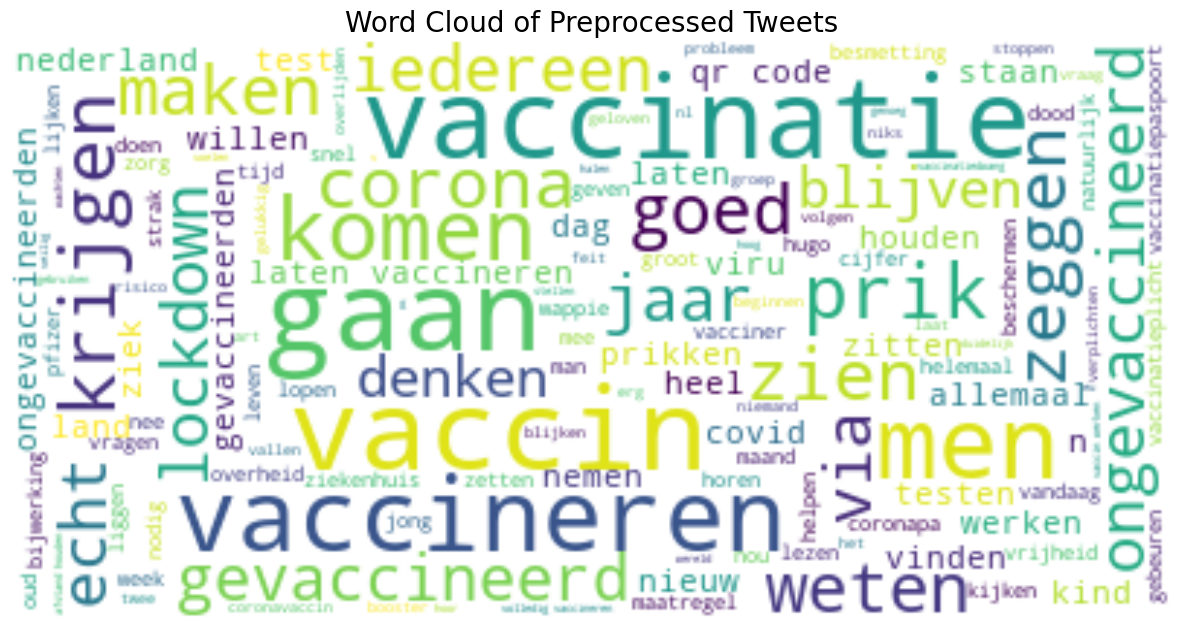

In [9]:
# TODO: plot figure(s)
# Worcloud figure
# Don't forget to pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    background_color='white',
    max_words=500,
    max_font_size=40,
    random_state=100
).generate(' '.join(processed_tweets))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Preprocessed Tweets", fontsize=20)
plt.show()


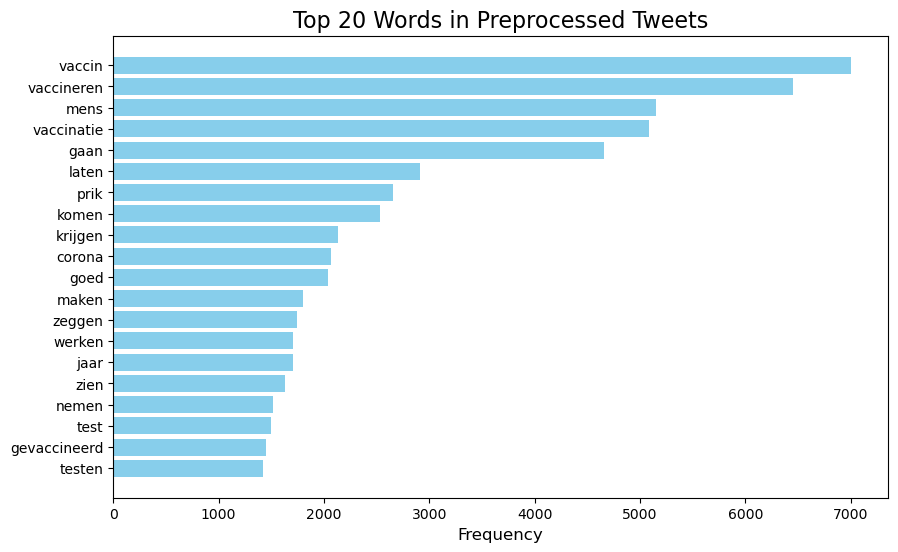

In [10]:
# TODO: plot figure(s)
from collections import Counter

# Counts word frequencies
word_counts = Counter(" ".join(processed_tweets).split())
most_common_words = word_counts.most_common(20)

# Extracts words and counts
words, counts = zip(*most_common_words)

# Word frequency plot
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.title("Top 20 Words in Preprocessed Tweets", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.show()


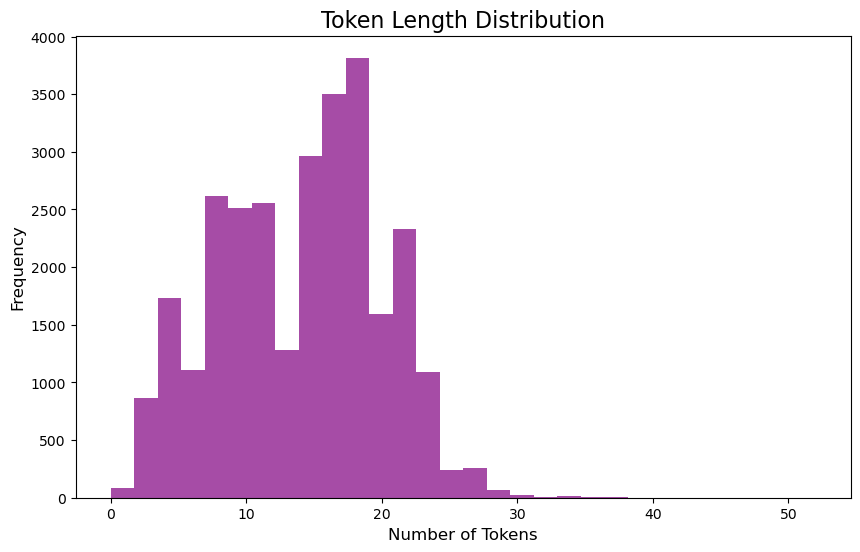

In [11]:
# TODO: plot figure(s)
# Calculates token lengths
token_lengths = [len(tweet.split()) for tweet in processed_tweets]

# Token length plot
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='purple', alpha=0.7)
plt.title("Token Length Distribution", fontsize=16)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


c:\Users\David\anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\David\anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


AttributeError: 'Rectangle' object has no property 'legend'

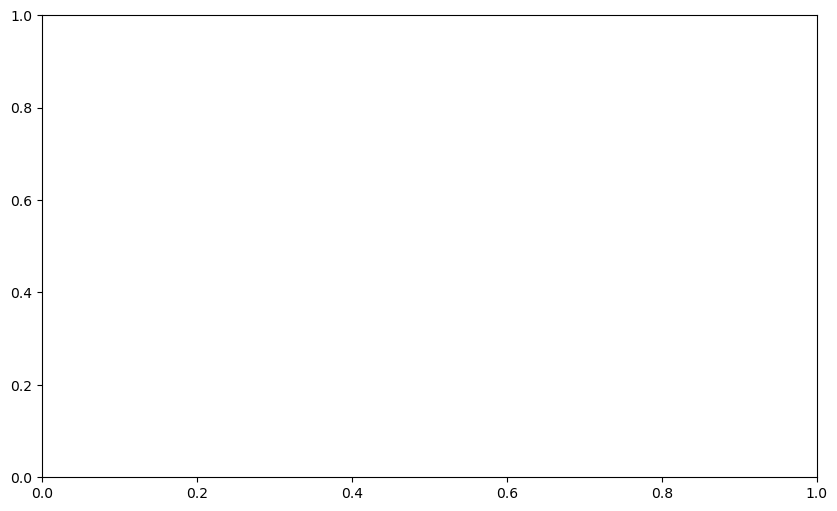

In [12]:
# TODO: plot figure(s)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import numpy as np

# Extracts bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(processed_tweets)
bigram_counts = np.asarray(X.sum(axis=0)).flatten()
bigram_features = vectorizer.get_feature_names_out()

# Creates dataframe of bigram frequencies
bigram_data = sorted(zip(bigram_counts, bigram_features), reverse=True)[:20]
counts, bigrams = zip(*bigram_data)

# Bigram plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(bigrams), hue=bigram_data, palette="viridis", legend=False)
plt.title("Top 20 Bigrams in Preprocessed Tweets", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Bigrams", fontsize=12)
plt.show()


## 2.1 Topic modelling and clustering
 In the second part of the assignment, you will first:
 -	Implement a Latent Dirichlet Allocation (LDA) algorithm to identify the discussed topics for your theme
 -	Implement a clustering method  to cluster messages into different groups, then represent the topic of each cluster using a bag of words

While implementing the algorithms, you may use the codes from the recommended packages. In the final report, please explain reasons to select the used algorithm/package. 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# TODO: topic modeling using the LDA algorithm
# Sets parameters and stop word list
dutch_stopwords = list(nlp.Defaults.stop_words)
vectorizer = CountVectorizer(max_features=1000, stop_words = dutch_stopwords)

# Converts to bag of words
bow = vectorizer.fit_transform(processed_tweets)
bow_feature_names = vectorizer.get_feature_names_out()

# sets lda parameters
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(bow)

# Displays sorted topics
print("LDA Topics:")
for i, topic in enumerate(lda_model.components_):
    top_words = [bow_feature_names[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i + 1}: {', '.join(top_words)}")


LDA Topics:
Topic 1: zorg, ziekenhuis, vinden, kind, gaan, maken, willen, laten, mens, vaccineren
Topic 2: verplichten, komen, vaccineren, vaccinatieplicht, avondklok, nederland, vaccinatiepaspoort, gaan, lockdown, vaccinatie
Topic 3: via, overlijden, pfizer, krijgen, corona, bijwerking, mens, covid, vaccinatie, vaccin
Topic 4: komen, laten, goed, jaar, mens, werken, nemen, gaan, prik, vaccin
Topic 5: houden, ongevaccineerden, gaan, gevaccineerden, ongevaccineerd, testen, qr, test, gevaccineerd, vaccineren



Cluster Descriptions:
Cluster 0: ['goed', 'vaccin', 'mens', 'vaccineren', 'gaan', 'werken', 'laten', 'prik', 'komen', 'heel']
Cluster 1: ['gaan', 'vaccineren', 'mens', 'vaccin', 'laten', 'prik', 'komen', 'corona', 'testen', 'zeggen']
Cluster 2: ['vaccineren', 'mens', 'prik', 'laten', 'komen', 'gevaccineerd', 'krijgen', 'ongevaccineerd', 'corona', 'ongevaccineerden']
Cluster 3: ['vaccinatie', 'mens', 'gaan', 'komen', 'corona', 'vaccineren', 'verplichten', 'maken', 'krijgen', 'laten']
Cluster 4: ['vaccin', 'mens', 'werken', 'krijgen', 'vaccineren', 'nemen', 'corona', 'komen', 'jaar', 'zeggen']


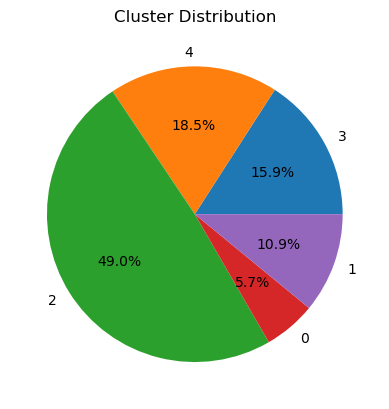

In [14]:
from sklearn.cluster import KMeans

# TODO: cluster the messages using a clustering algorithm
# K-Means Clustering
n_clusters = 5
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(bow)

# Clusters Descriptions
labels = kmeans_model.labels_
cluster_descriptions = []

print("\nCluster Descriptions:")
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_words = Counter(word for idx in cluster_indices for word in processed_tweets[idx].split()).most_common(10)
    cluster_descriptions.append(cluster_words)
    print(f"Cluster {cluster_id}: {[word for word, count in cluster_words]}")

# Cluster distribution visualizaiton
cluster_sizes = Counter(labels)
plt.pie(cluster_sizes.values(), labels=cluster_sizes.keys(), autopct="%1.1f%%")
plt.title("Cluster Distribution")
plt.show()


 ## 2.2 Results, evaluation and Interpretation 
 
Finally, you will describe, evaluate and interpret your findings from two methods. 

- In the report, you need to describe and discuss the similarity and difference of results from two methods.
- While evaluating the results, human judgment is very important, so visualization techniques are helpful to evaluate the identified topics in an interpreted manner. 
    
1. For evaluating the topic modelling algorithm, please first use the interactive tool **[pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=)** to examine the inter-topic separation of your findings. 

2. For interpreting the identified topics / clusters of both algorithms, we provide example code for several visualization techiques. You can use multiple ones to evaluate your results or come up with visualisations on your own. The files contain examples for how to use the visualisation functions.


In [ ]:
# TODO: evaluation 


import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 
warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()


pyLDAvis.lda_model.prepare(lda_model, bow, vectorizer, n_jobs=1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009722 -0.083764       1        1  25.950076
2      0.102394  0.078056       2        1  21.396767
1     -0.112468  0.167540       3        1  18.444992
3      0.184213 -0.047534       4        1  17.958979
4     -0.164417 -0.114297       5        1  16.249186, topic_info=           Term         Freq        Total Category  logprob  loglift
820      vaccin  7413.000000  7413.000000  Default  30.0000  30.0000
772        test  1746.000000  1746.000000  Default  29.0000  29.0000
454       laten  2880.000000  2880.000000  Default  28.0000  28.0000
837  vaccineren  6442.000000  6442.000000  Default  27.0000  27.0000
821  vaccinatie  5320.000000  5320.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
496       maken   336.087582  1794.333065   Topic5  -4.8504   0.1421
172         dag   280.128644   891.774590   Topic5  -5.0326   0.6592
430        kind   292.545515  1264.826432   Topic5  -4.9892   0.3531
435       komen   311.001932  2531.151747   Topic5  -4.9280  -0.2795
370    iedereen   284.619879  1337.796298   Topic5  -5.0166   0.2695

[340 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         5  0.986209        00
2         2  0.813722        19
2         3  0.182517        19
2         4  0.002535        19
6         2  0.858019  aandacht
...     ...       ...       ...
992       2  0.001221      zorg
992       3  0.472583      zorg
992       4  0.013433      zorg
992       5  0.008548      zorg
999       3  0.993493    zweden

[765 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

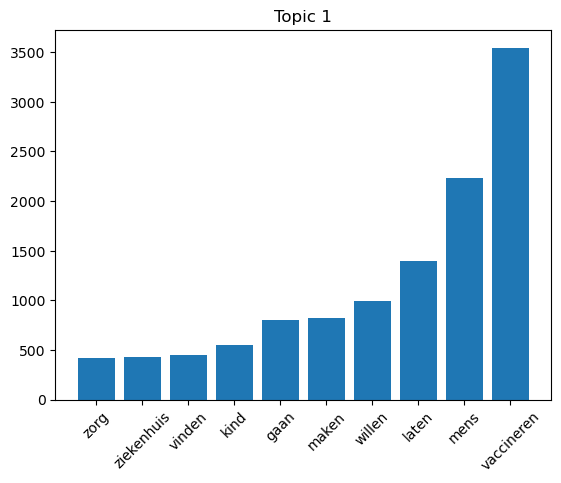

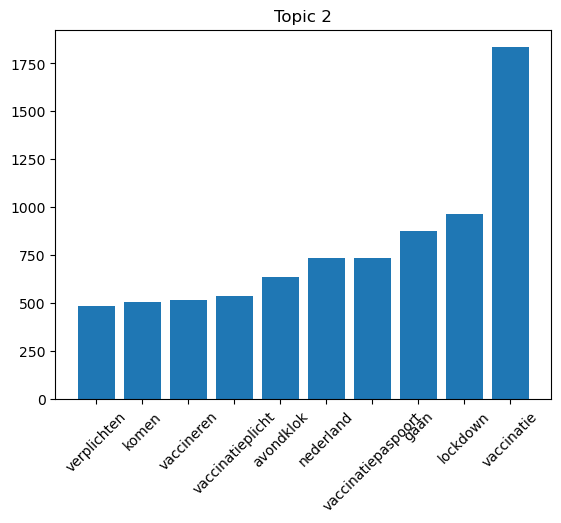

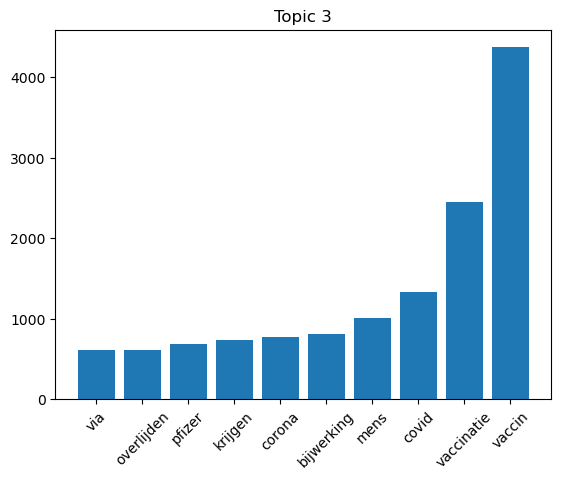

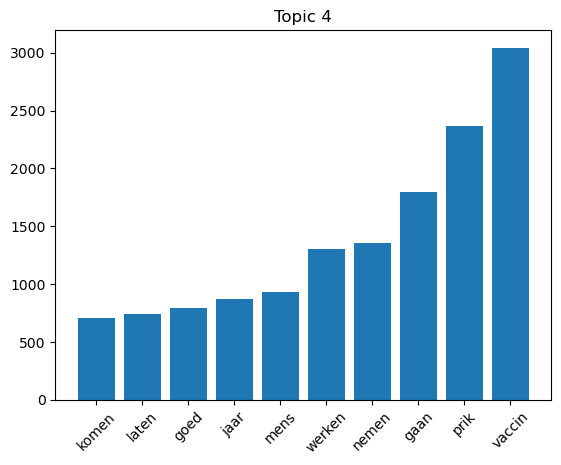

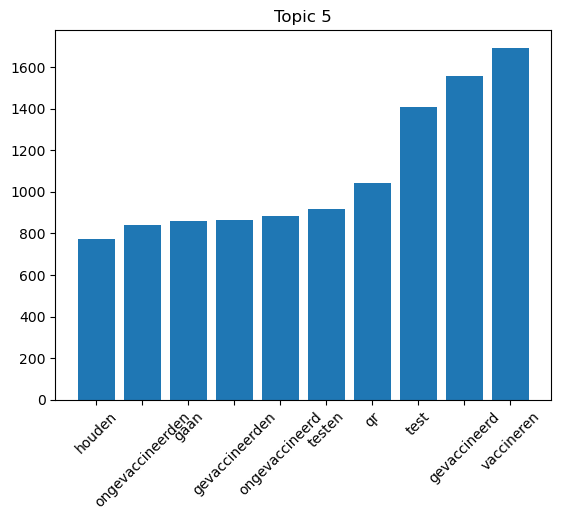

In [41]:
# Bar charts for each topic of the LDA
for i, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[-10:]
    top_words = [bow_feature_names[j] for j in top_indices]
    top_scores = topic[top_indices]
    
    # Create plot
    plt.bar(top_words, top_scores)
    plt.title(f"Topic {i + 1}")
    plt.xticks(rotation=45)
    plt.show()


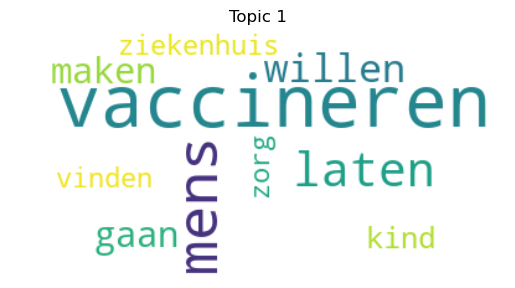

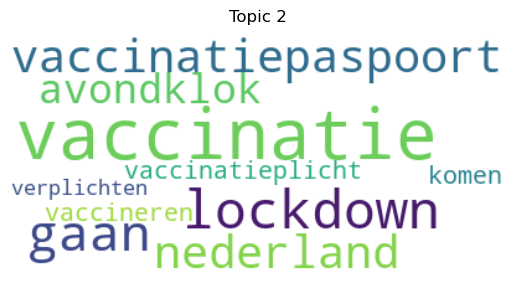

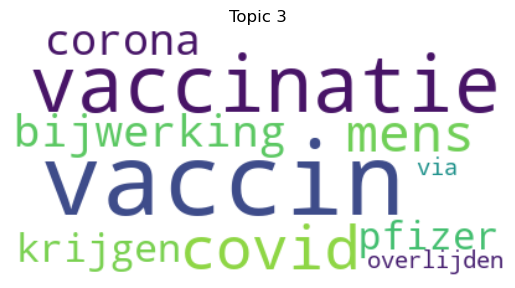

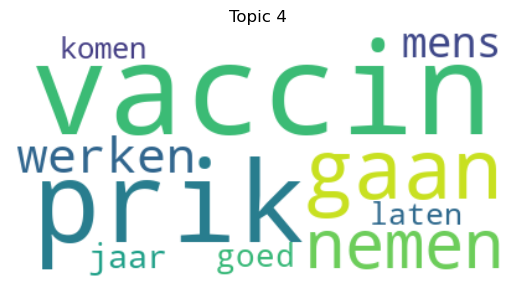

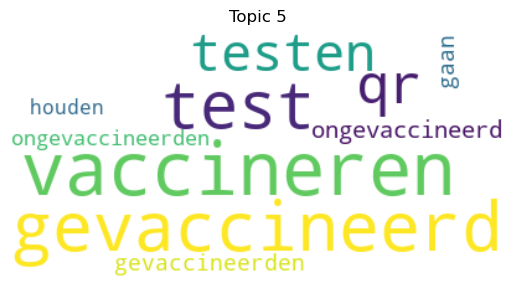

In [ ]:
# Word cloud visualization for each cluster of the Kmeans

for i, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[-10:]
    word_freq = {bow_feature_names[j]: topic[j] for j in top_indices}
    
    #create word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i + 1}")
    plt.show()


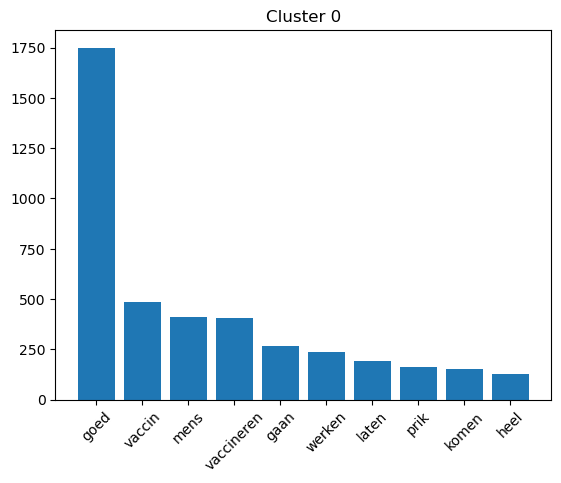

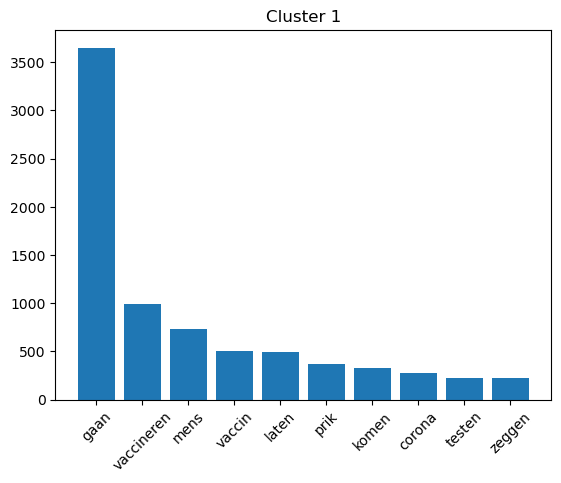

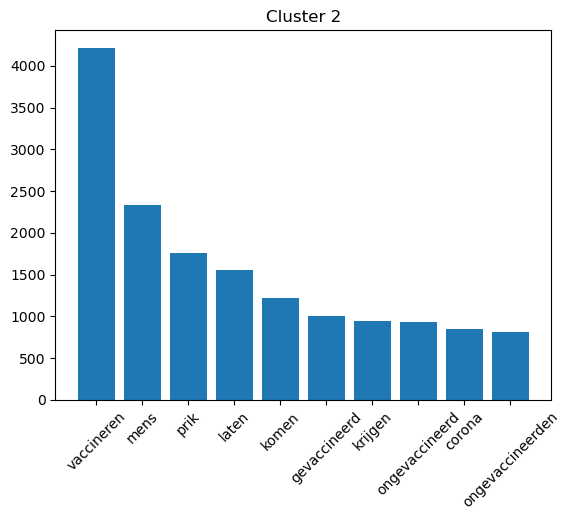

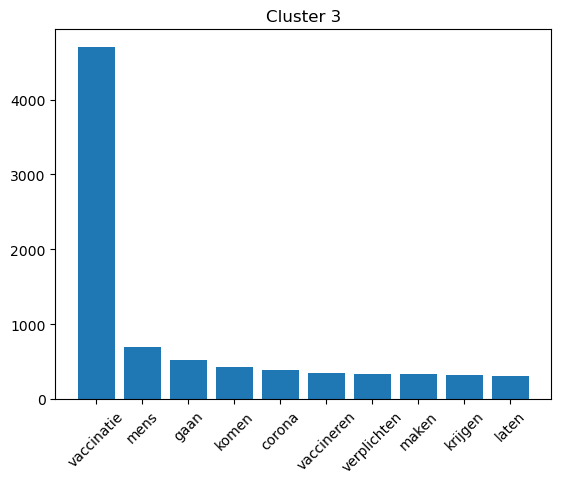

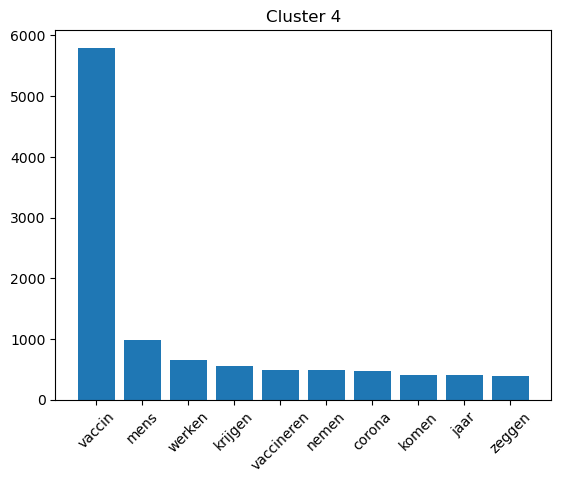

In [40]:
# Bar charts for each cluster of the Kmeans
for cluster_id, words in enumerate(cluster_descriptions):
    word_labels, counts = zip(*words)

    #create plot
    plt.bar(word_labels, counts)
    plt.title(f"Cluster {cluster_id}")
    plt.xticks(rotation=45)
    plt.show()


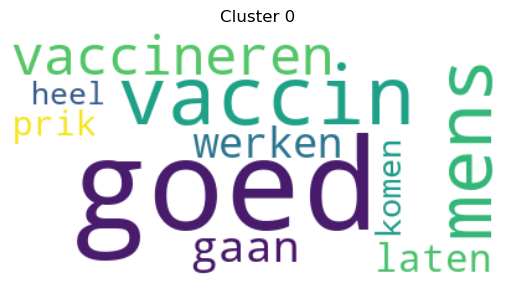

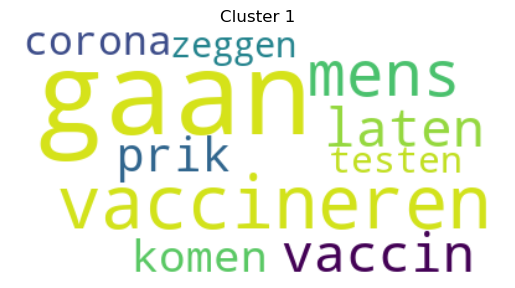

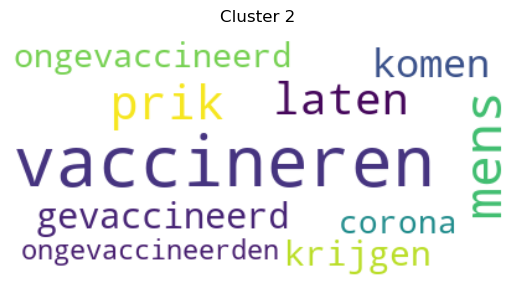

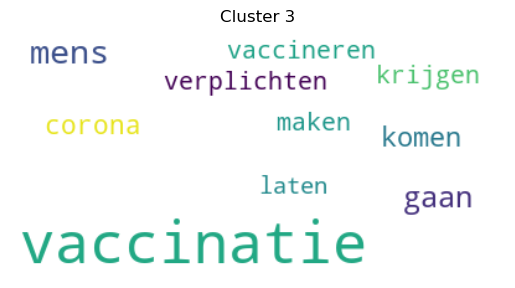

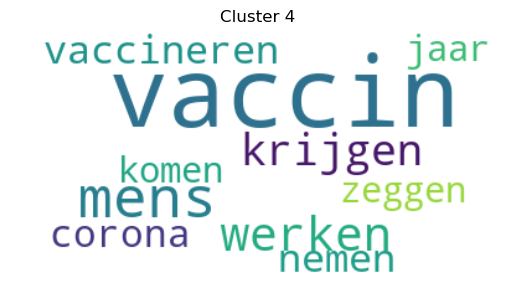

In [44]:
# Word cloud visualization for each cluster of the Kmeans
for cluster_id, words in enumerate(cluster_descriptions):
    word_freq = {word: count for word, count in words}
    
    # Create word could
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster_id}")
    plt.show()


# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Use an LLM-based topic modeling method (for instance, **[BERTopic](https://maartengr.github.io/BERTopic/index.html)** or **[Fastopic](https://github.com/BobXWu/Fastopic)** to identify topics for your theme. Discuss your findings and explain why your chosen method is better (or worse) than LDA.

2. Can you think of other evaluation methods than the provided visualization techniques? If so, implement one and explain why it is a good evaluation for our task.

In [15]:
from fastopic import FASTopic
from topmost.preprocessing import Preprocessing


preprocessing = Preprocessing(vocab_size=10000, stopwords='Dutch')

model = FASTopic(50, preprocessing)
topic_top_words, doc_topic_dist = model.fit_transform(processed_tweets)

parsing texts: 100%|██████████| 28667/28667 [00:00<00:00, 35975.45it/s]
2025-01-07 16:14:20,477 - TopMost - Real vocab size: 10000
2025-01-07 16:14:20,899 - TopMost - Real training size: 28667 	 avg length: 12.764
Training FASTopic: 100%|██████████| 200/200 [10:31<00:00,  3.16s/it]


In [16]:
fig = model.visualize_topic(top_n=5)
fig.show()

In [13]:
fig = model.visualize_topic_hierarchy()
fig.show()


In [14]:
fig = model.visualize_topic_weights(top_n=20, height=500)
fig.show()